In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import Ridge


In [2]:
patient_df = pd.read_excel('./dataset/Patient_Data.xlsx')
provider_df = pd.read_excel('./dataset/Provider_Data_Joined.xlsx')

In [3]:
enrollment_to_spend_column = {
    'Aged': 'AGED_TOTAL_SPEND',
    'Disabled': 'DISABLED_TOTAL_SPEND',
    'ESRD': 'ESRD_TOTAL_ESRD',
    'Aged-Dual': 'AGED_DUAL_TOTAL_SPEND'
}

patient_df['Mapped_Spend_Column'] = patient_df['ENROLLMENT_TYPE'].map(enrollment_to_spend_column)


melted_provider_df = provider_df.melt(id_vars=['PERFORMANCE_YEAR', 'TIN_CCN'], 
                                      value_vars=['AGED_TOTAL_SPEND', 'DISABLED_TOTAL_SPEND', 'ESRD_TOTAL_ESRD', 'AGED_DUAL_TOTAL_SPEND'],
                                      var_name='Mapped_Spend_Column', value_name='Spend_by_ENROLLMENT_TYPE')

merged_df = pd.merge(patient_df, melted_provider_df, 
                     left_on=['PERFORMANCE_YEAR', 'TIN_CCN', 'Mapped_Spend_Column'], 
                     right_on=['PERFORMANCE_YEAR', 'TIN_CCN', 'Mapped_Spend_Column'],
                     how='left')
merged_df.fillna(0,inplace=True)
patient_df = merged_df.drop(['Mapped_Spend_Column'],axis=1)
patient_df.to_excel('./dataset/Patient_Data.xlsx',index=False)
provider_df.drop(['AGED_TOTAL_SPEND','DISABLED_TOTAL_SPEND','ESRD_TOTAL_ESRD','AGED_DUAL_TOTAL_SPEND'],axis=1,inplace=True)
provider_df.to_excel('./dataset/Provider_Data_Joined.xlsx',index=False)

In [4]:
provider_df.head(10)

,PERFORMANCE_YEAR,QRO,TIN_CCN,SUM_IP_SPEND,SUM_FAC_OP_SPEND,SUM_PHY_SPEND,SUM_POSTACUTE_SPEND,SUM_HOSPICE_SPEND,SUM_DME_SPEND,ED_VISIT_RATE,ED_RETURN_72HRS,IP_ADMIT_RATE,READMIT_30DAY_RATE,AWV_RATE,SUM_PCP_VISITS,CNT_PCP_VISITS,SUM_SPEC_VISITS,CNT_SPEC_VISITS
0,2019,MTIP,122406,0.00,11329.40,7003.38,0.00,0.00,0.00,166.7,1.000,278.515108,0.137765,0.000,988.59,10,460.16,12
1,2019,MTIP,679036,0.00,122.30,0.00,0.00,0.00,0.00,0.0,0.000,0.000000,0.000000,0.000,122.30,1,0.00,0
2,2019,MTIP,344888,0.00,8.79,0.00,0.00,0.00,0.00,0.0,0.000,0.000000,0.000000,0.000,8.79,1,0.00,0
3,2019,MTIP,125904,48225.71,134299.70,101493.16,12408.65,0.00,25392.39,1062.5,0.735,218.800000,0.137765,0.438,26994.97,260,9199.88,153
4,2019,MTIP,183834,19192504.70,16020228.69,9062788.08,4477877.38,1320060.30,1349982.92,797.1,0.758,307.500000,0.139000,0.441,1464784.77,23075,1050828.72,17304
5,2019,MTIP,496926,8349692.58,7973268.19,4120389.79,2062108.87,386510.00,809313.60,1004.5,0.779,354.000000,0.145000,0.260,1244567.92,10951,471142.99,7624
6,2019,MTIP,834843,5364179.15,4602899.62,3152931.99,1253099.57,433572.46,548635.03,688.6,0.696,230.100000,0.094000,0.120,954668.84,8647,263161.19,4254
7,2019,NTVP,781599,173285.78,77484.92,82410.87,38663.52,24292.54,20873.07,1576.9,0.659,307.700000,0.125000,0.269,15517.85,138,4717.13,63
8,2019,NTVP,592226,204133.09,205026.42,100282.72,42342.66,18145.17,20507.22,764.7,0.795,254.900000,0.137765,0.118,23402.84,269,9539.52,151
9,2019,NTVP,604033,14219144.68,15605275.94,7850739.14,2978073.88,1096923.82,1191230.15,713.5,0.747,245.600000,0.116000,0.356,3345490.93,25061,691382.89,10660


## Cluster


In [5]:
columns_to_normalize = [
    'SUM_IP_SPEND', 'SUM_FAC_OP_SPEND', 'SUM_PHY_SPEND', 'SUM_POSTACUTE_SPEND',
    'SUM_HOSPICE_SPEND', 'SUM_DME_SPEND'
    # ,'ED_VISIT_RATE', 'ED_RETURN_72HRS',
    # 'IP_ADMIT_RATE','READMIT_30DAY_RATE','AWV_RATE','CNT_PCP_VISITS','CNT_SPEC_VISITS'
]
scaler = StandardScaler()
normalized_data = scaler.fit_transform(provider_df[columns_to_normalize])
pca = PCA(n_components=2)
pca_results = pca.fit_transform(normalized_data)
pca_results[:10]

array([[-6.04168218e-01, -2.39201597e-02],
       [-6.05088790e-01, -2.35047930e-02],
       [-6.05092773e-01, -2.35021785e-02],
       [-5.81698014e-01, -3.54484675e-02],
       [ 3.43141959e+00,  9.51431413e-01],
       [ 1.15103663e+00,  5.81100328e-02],
       [ 6.67511963e-01,  2.78396010e-01],
       [-5.60195428e-01,  1.92290284e-03],
       [-5.57040352e-01, -1.03011967e-02],
       [ 2.67582518e+00,  6.74845532e-01]])

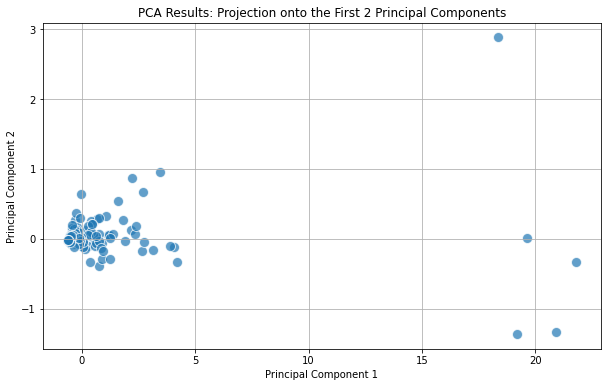

In [6]:
plt.figure(figsize=(10, 6))
plt.scatter(pca_results[:, 0], pca_results[:, 1], alpha=0.7, edgecolors='w', s=100)
plt.title('PCA Results: Projection onto the First 2 Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

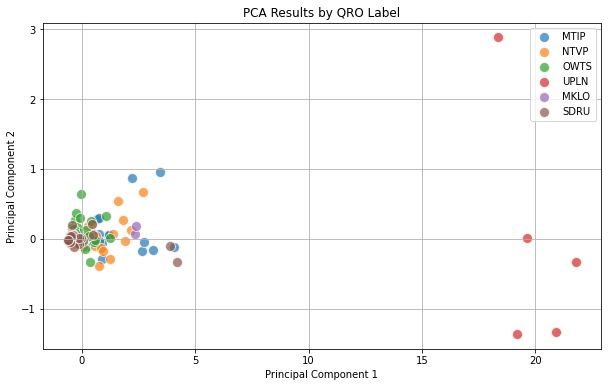

In [7]:
unique_QRO = provider_df['QRO'].unique()
pca_df = pd.DataFrame(pca_results,columns=['PC1','PC2'])
pca_df['QRO'] = provider_df['QRO']

plt.figure(figsize=(10,6))
for label in unique_QRO:
    subset = pca_df[pca_df['QRO'] == label]
    plt.scatter(subset['PC1'],subset['PC2'],label=label,alpha=0.7,edgecolors='w',s=100)

plt.title('PCA Results by QRO Label')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
provider_df[provider_df.QRO=='UPLN']

,PERFORMANCE_YEAR,QRO,TIN_CCN,SUM_IP_SPEND,SUM_FAC_OP_SPEND,SUM_PHY_SPEND,SUM_POSTACUTE_SPEND,SUM_HOSPICE_SPEND,SUM_DME_SPEND,ED_VISIT_RATE,ED_RETURN_72HRS,IP_ADMIT_RATE,READMIT_30DAY_RATE,AWV_RATE,SUM_PCP_VISITS,CNT_PCP_VISITS,SUM_SPEC_VISITS,CNT_SPEC_VISITS
36,2019,UPLN,430950,8.544768e+07,7.822179e+07,38538912.62,19358636.27,5720443.16,9926466.01,711.7,0.725,311.9,0.155,0.538,5301353.91,92567,4853907.06,79657
78,2020,UPLN,430950,1.085706e+08,8.835376e+07,40798211.80,18870273.58,3884250.87,13198513.82,587.5,0.697,281.2,0.160,0.499,5320521.76,96600,5698056.74,90345
150,2021,UPLN,430950,1.157051e+08,1.029321e+08,49861810.98,19439312.55,5146075.20,13704945.35,627.0,0.664,298.6,0.166,0.521,7081575.74,103652,8110220.90,105152
262,2022,UPLN,430950,1.035069e+08,1.140001e+08,48869509.68,18873166.67,4383509.25,13221610.67,616.4,0.581,284.9,0.167,0.566,7499218.50,103337,7637417.84,101539
374,2023,UPLN,430950,9.120167e+07,1.038906e+08,45205399.56,16566489.25,4959034.98,12522399.53,570.2,0.347,263.1,0.144,0.557,7187374.93,98494,6912164.51,94264


/Users/wzyy/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/wzyy/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/wzyy/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/wzyy/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will chang

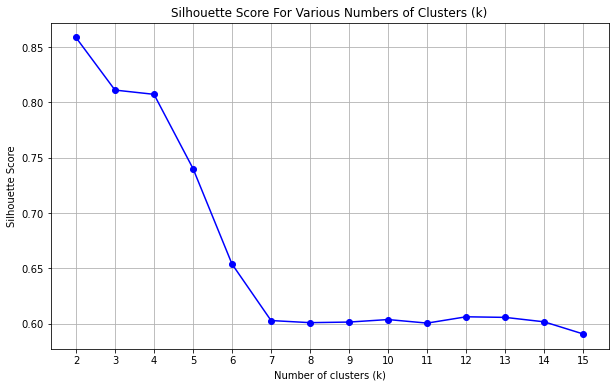

(2, 0.8588386583188086)

In [9]:
pca_with_qro_filtered = pca_df[pca_df['QRO'] != 'UPLN']

silhouette_scores = []
K_range_silhouette = range(2, 16)

for k in K_range_silhouette:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(pca_with_qro_filtered[['PC1', 'PC2']])
    silhouette_avg = silhouette_score(pca_with_qro_filtered[['PC1', 'PC2']], cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plotting the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(K_range_silhouette, silhouette_scores, 'bo-')
plt.title('Silhouette Score For Various Numbers of Clusters (k)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(K_range_silhouette)
plt.grid(True)
plt.show()

# Finding the k with the highest silhouette score
best_k = K_range_silhouette[silhouette_scores.index(max(silhouette_scores))]
best_k, max(silhouette_scores)

/Users/wzyy/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
<ipython-input-10-615cb3db6ce4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pca_with_qro_filtered['Cluster'] = kmeans.fit_predict(pca_with_qro_filtered[['PC1', 'PC2']])


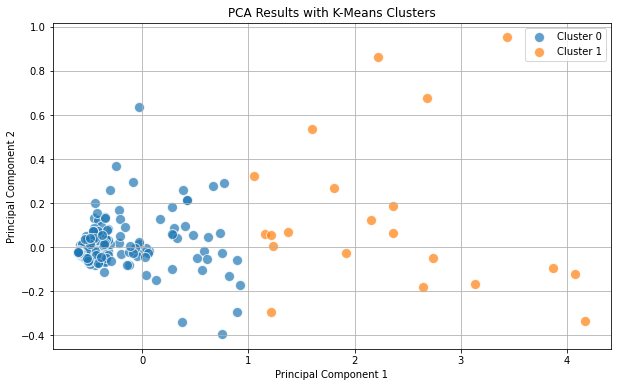

In [10]:
kmeans = KMeans(n_clusters=2,random_state=42)
pca_with_qro_filtered['Cluster'] = kmeans.fit_predict(pca_with_qro_filtered[['PC1', 'PC2']])
plt.figure(figsize=(10,6))
for cluster_id in np.unique(pca_with_qro_filtered['Cluster']):
    subset = pca_with_qro_filtered[pca_with_qro_filtered['Cluster'] == cluster_id]
    plt.scatter(subset['PC1'],subset['PC2'],label=f'Cluster {cluster_id}', alpha=0.7, edgecolors='w', s=100)

plt.title('PCA Results with K-Means Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()

<ipython-input-11-944a2751a842>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pca_with_qro_filtered['Cluster'] = kmeans.labels_


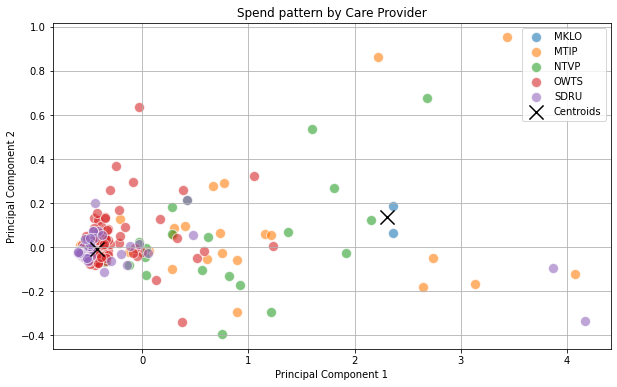

In [11]:
centroids = kmeans.cluster_centers_

pca_with_qro_filtered['Cluster'] = kmeans.labels_
# Creating a new plot for centroids
plt.figure(figsize=(10, 6))
# plt.scatter(pca_with_qro_filtered['PC1'],pca_with_qro_filtered['PC2'], c=kmeans.labels_, cmap='viridis', marker='o', alpha=0.6, label='Data Points')
for label, df_subset in pca_with_qro_filtered.groupby('QRO'):
    plt.scatter(df_subset['PC1'], df_subset['PC2'], label=label, alpha=0.6, edgecolors='w', s=100)
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='x', s=200, label='Centroids')
plt.title('Spend pattern by Care Provider')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(loc='best')
plt.grid(True)
plt.show()

## Correlation

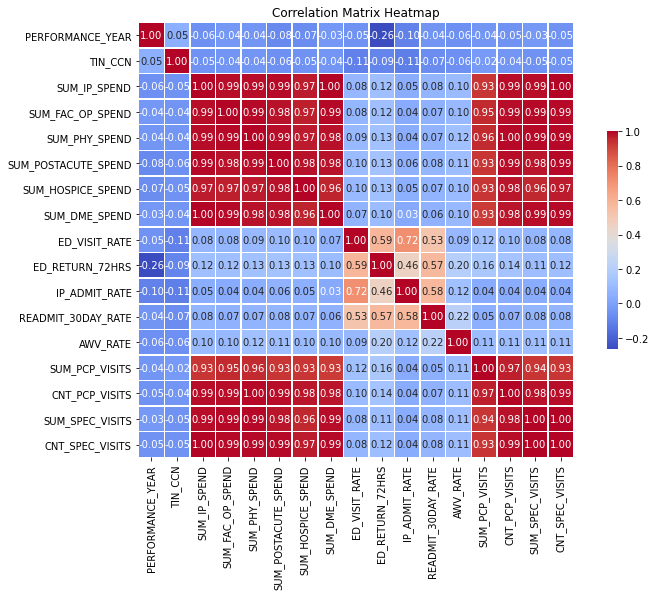

In [12]:
plt.figure(figsize=(12, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(provider_df.corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True, 
            cbar_kws={"shrink": .5}, linewidths=.5)

plt.title('Correlation Matrix Heatmap')
plt.show()


In [13]:
spend_columns = ['SUM_IP_SPEND', 'SUM_FAC_OP_SPEND', 'SUM_PHY_SPEND', 'SUM_POSTACUTE_SPEND', 
                 'SUM_HOSPICE_SPEND', 'SUM_DME_SPEND']
rate_columns = ['ED_RETURN_72HRS', 'READMIT_30DAY_RATE']

correlation_matrix = provider_df[spend_columns + rate_columns].corr()
ed_return_correlations = correlation_matrix.loc['ED_RETURN_72HRS', spend_columns]
readmit_rate_correlations = correlation_matrix.loc['READMIT_30DAY_RATE', spend_columns]

print("Correlations with ED_RETURN_72HRS:")
print(ed_return_correlations)
print("\nCorrelations with READMIT_30DAY_RATE:")
print(readmit_rate_correlations)

Correlations with ED_RETURN_72HRS:
SUM_IP_SPEND           0.121893
SUM_FAC_OP_SPEND       0.117688
SUM_PHY_SPEND          0.128741
SUM_POSTACUTE_SPEND    0.134106
SUM_HOSPICE_SPEND      0.125463
SUM_DME_SPEND          0.103516
Name: ED_RETURN_72HRS, dtype: float64

Correlations with READMIT_30DAY_RATE:
SUM_IP_SPEND           0.075674
SUM_FAC_OP_SPEND       0.066102
SUM_PHY_SPEND          0.072715
SUM_POSTACUTE_SPEND    0.080696
SUM_HOSPICE_SPEND      0.069712
SUM_DME_SPEND          0.064841
Name: READMIT_30DAY_RATE, dtype: float64


In [14]:
patient_df.head(5)

,PERFORMANCE_YEAR,QRO,TIN_CCN,ENROLLMENT_TYPE,BENE_CNT,AVR_RISK_SCORE,AVR_RISK_SCORE_STANDARDIZED,Spend_by_ENROLLMENT_TYPE
0,2022,MKLO,866020,ESRD,10,1.861,2.117089,515432.67
1,2022,MKLO,866020,Unknown,109,0.736,-0.495252,0.00
2,2022,MKLO,866020,Aged-Dual,344,0.876,-0.170161,3925897.72
3,2022,MKLO,866020,Disabled,713,0.863,-0.200348,5907116.67
4,2022,MKLO,866020,Aged,2868,0.940,-0.021548,28060454.45


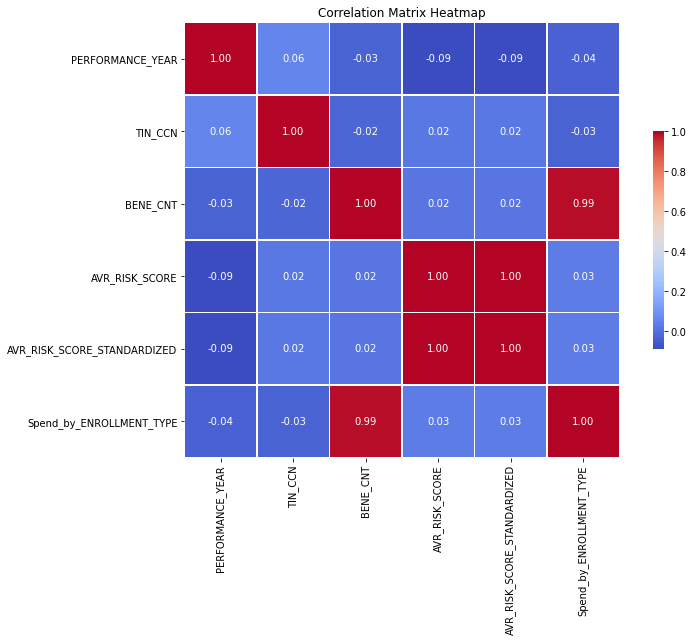

In [15]:
plt.figure(figsize=(12, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(patient_df.corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True, 
            cbar_kws={"shrink": .5}, linewidths=.5)

plt.title('Correlation Matrix Heatmap')
plt.show()


## Care Quality

In [16]:
care_df = provider_df[['PERFORMANCE_YEAR','QRO','TIN_CCN','ED_VISIT_RATE','ED_RETURN_72HRS',
    'IP_ADMIT_RATE','READMIT_30DAY_RATE','AWV_RATE']]
care_df = care_df[(care_df['ED_RETURN_72HRS'] != 0) & (care_df['READMIT_30DAY_RATE'] != 0)]
care_df

,PERFORMANCE_YEAR,QRO,TIN_CCN,ED_VISIT_RATE,ED_RETURN_72HRS,IP_ADMIT_RATE,READMIT_30DAY_RATE,AWV_RATE
0,2019,MTIP,122406,166.7,1.000000,278.515108,0.137765,0.000
3,2019,MTIP,125904,1062.5,0.735000,218.800000,0.137765,0.438
4,2019,MTIP,183834,797.1,0.758000,307.500000,0.139000,0.441
5,2019,MTIP,496926,1004.5,0.779000,354.000000,0.145000,0.260
6,2019,MTIP,834843,688.6,0.696000,230.100000,0.094000,0.120
...,...,...,...,...,...,...,...,...
370,2023,SDRU,877376,420.7,0.217000,189.000000,0.065000,0.189
371,2023,SDRU,556858,2153.8,0.500000,653.800000,0.176000,0.115
372,2023,SDRU,676890,552.9,0.511000,235.300000,0.250000,0.671
373,2023,SDRU,680049,142.9,0.550516,47.600000,0.137765,1.000


In [17]:
care_df[['ED_RETURN_72HRS','READMIT_30DAY_RATE']].agg(['mean','median'])

,ED_RETURN_72HRS,READMIT_30DAY_RATE
mean,0.550516,0.137765
median,0.550516,0.137765


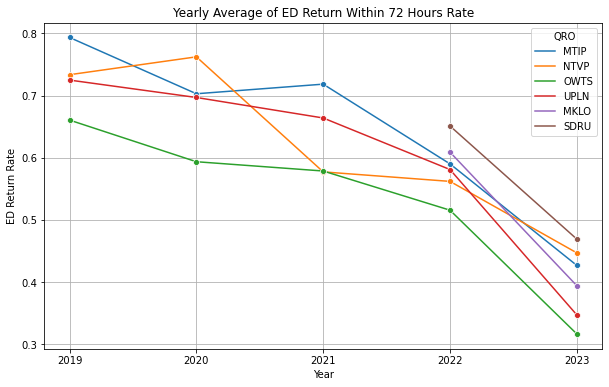

In [18]:
yearly_avg = care_df.groupby(['PERFORMANCE_YEAR','QRO'])[['ED_RETURN_72HRS','READMIT_30DAY_RATE']].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.lineplot(data=yearly_avg, x='PERFORMANCE_YEAR', y='ED_RETURN_72HRS', marker='o',hue='QRO')
plt.title('Yearly Average of ED Return Within 72 Hours Rate')
plt.xlabel('Year')
plt.ylabel('ED Return Rate')
plt.grid(True)
plt.xticks(yearly_avg['PERFORMANCE_YEAR'].unique(), yearly_avg['PERFORMANCE_YEAR'].unique().astype(int))
plt.show()


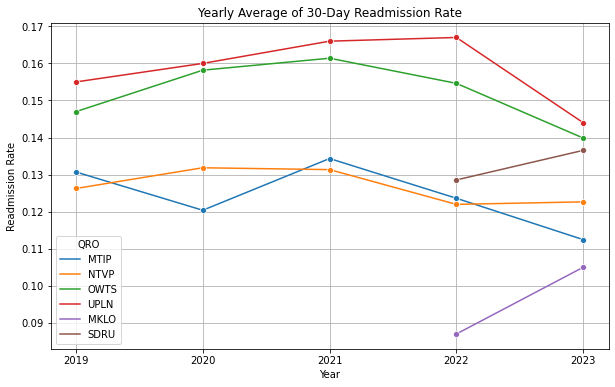

In [19]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=yearly_avg, x='PERFORMANCE_YEAR', y='READMIT_30DAY_RATE', marker='o', hue='QRO')
plt.title('Yearly Average of 30-Day Readmission Rate')
plt.xlabel('Year')
plt.ylabel('Readmission Rate')
plt.grid(True)
# Ensure x-axis labels are integers
plt.xticks(yearly_avg['PERFORMANCE_YEAR'].unique(), yearly_avg['PERFORMANCE_YEAR'].unique().astype(int))
plt.show()


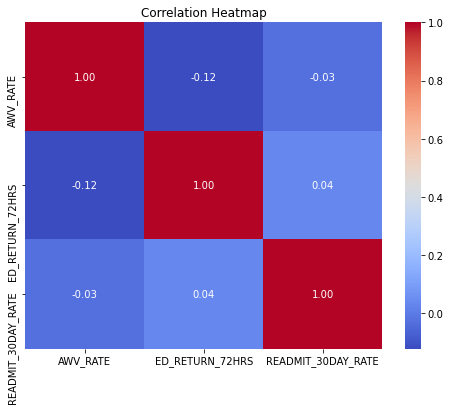

In [20]:
care_corr_matrix = care_df[['AWV_RATE', 'ED_RETURN_72HRS', 'READMIT_30DAY_RATE']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(care_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

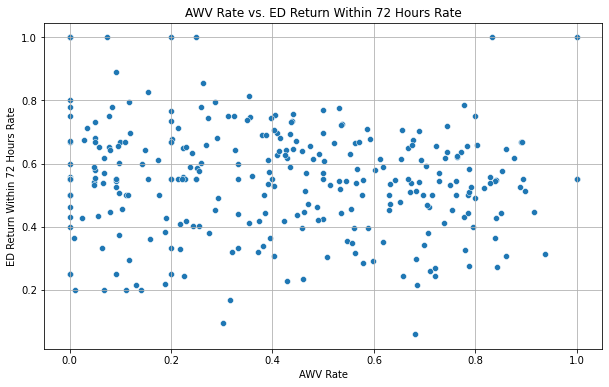

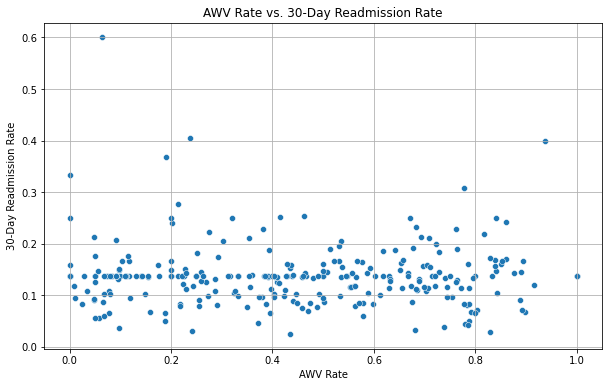

In [21]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=care_df, x='AWV_RATE', y='ED_RETURN_72HRS')
plt.title('AWV Rate vs. ED Return Within 72 Hours Rate')
plt.xlabel('AWV Rate')
plt.ylabel('ED Return Within 72 Hours Rate')
plt.grid(True)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=care_df, x='AWV_RATE', y='READMIT_30DAY_RATE')
plt.title('AWV Rate vs. 30-Day Readmission Rate')
plt.xlabel('AWV Rate')
plt.ylabel('30-Day Readmission Rate')
plt.grid(True)
plt.show()


<ipython-input-22-527c01f67987>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  quality_metrics_agg = care_df.groupby(['QRO','TIN_CCN'])['ED_RETURN_72HRS', 'READMIT_30DAY_RATE'].mean().reset_index()


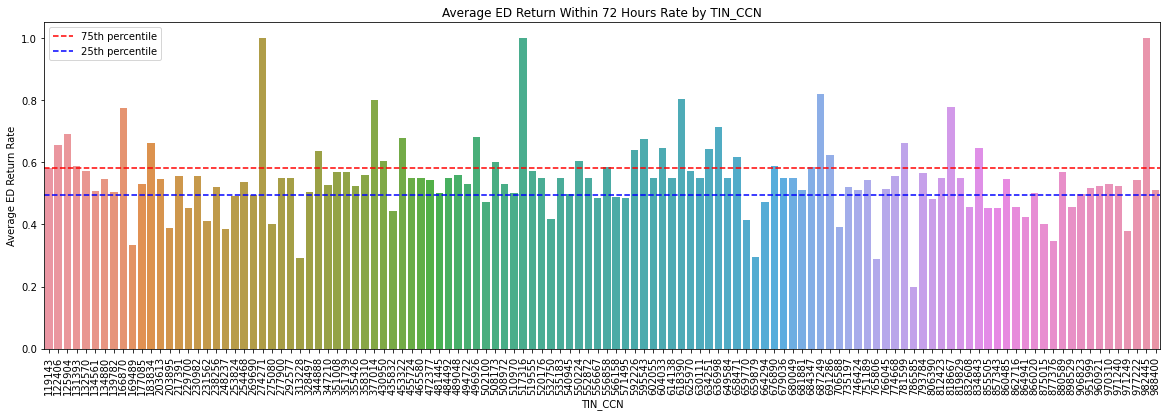

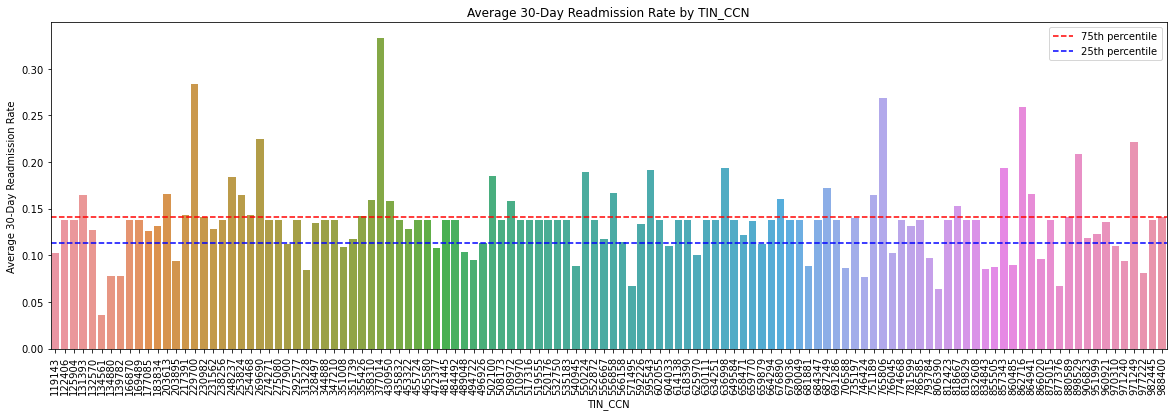

In [22]:
quality_metrics_agg = care_df.groupby(['QRO','TIN_CCN'])['ED_RETURN_72HRS', 'READMIT_30DAY_RATE'].mean().reset_index()
ed_return_75th = quality_metrics_agg['ED_RETURN_72HRS'].quantile(0.75)
ed_return_25th = quality_metrics_agg['ED_RETURN_72HRS'].quantile(0.25)

# Plot for ED_RETURN_72HRS with percentile lines
plt.figure(figsize=(20, 6))
sns.barplot(data=quality_metrics_agg, x='TIN_CCN', y='ED_RETURN_72HRS')
plt.axhline(ed_return_75th, color='red', linestyle='--', label='75th percentile')
plt.axhline(ed_return_25th, color='blue', linestyle='--', label='25th percentile')
plt.title('Average ED Return Within 72 Hours Rate by TIN_CCN')
plt.xticks(rotation=90)
plt.xlabel('TIN_CCN')
plt.ylabel('Average ED Return Rate')
plt.legend()
plt.show()

# Calculate percentiles for READMIT_30DAY_RATE
readmit_75th = quality_metrics_agg['READMIT_30DAY_RATE'].quantile(0.75)
readmit_25th = quality_metrics_agg['READMIT_30DAY_RATE'].quantile(0.25)

# Plot for READMIT_30DAY_RATE with percentile lines
plt.figure(figsize=(20, 6))
sns.barplot(data=quality_metrics_agg, x='TIN_CCN', y='READMIT_30DAY_RATE')
plt.axhline(readmit_75th, color='red', linestyle='--', label='75th percentile')
plt.axhline(readmit_25th, color='blue', linestyle='--', label='25th percentile')
plt.title('Average 30-Day Readmission Rate by TIN_CCN')
plt.xticks(rotation=90)
plt.xlabel('TIN_CCN')
plt.ylabel('Average 30-Day Readmission Rate')
plt.legend()
plt.show()

In [23]:
# Perform an ANOVA to test the differences in ED_RETURN_72HRS across TIN_CCNs
f_value, p_value = stats.f_oneway(*[group['ED_RETURN_72HRS'].values for name, group in care_df.groupby('TIN_CCN')])
print(f'ANOVA result on ED_RETURN_72HRS: F = {f_value}, p = {p_value}')

# Perform an ANOVA to test the differences in READMIT_30DAY_RATE across TIN_CCNs
f_value, p_value = stats.f_oneway(*[group['READMIT_30DAY_RATE'].values for name, group in care_df.groupby('TIN_CCN')])
print(f'ANOVA result on READMIT_30DAY_RATE: F = {f_value}, p = {p_value}')

ANOVA result on ED_RETURN_72HRS: F = 0.9919341537664672, p = 0.5143263840658846
ANOVA result on READMIT_30DAY_RATE: F = 1.4316292506189798, p = 0.013399589965796502


Based on these ANOVA results, there is evidence that care quality, as measured by these two metrics, varies significantly between different provider identifiers on 30 days readmition rate. These findings warrant further investigation into which specific TIN_CCNs differ from others and the potential reasons behind these differences. 

In [ ]:
# For ED_RETURN_72HRS
tukey_ed = pairwise_tukeyhsd(endog=care_df['ED_RETURN_72HRS'],     # Data
                             groups=care_df['TIN_CCN'],   # Groups
                             alpha=0.05)             # Significance level

# For READMIT_30DAY_RATE
tukey_readmit = pairwise_tukeyhsd(endog=care_df['READMIT_30DAY_RATE'],  # Data
                                  groups=care_df['TIN_CCN'],            # Groups
                                  alpha=0.05)                      # Significance level

# Print the test results
print(tukey_ed)
print(tukey_readmit)


In [39]:
# Convert the Tukey HSD results to a DataFrame for easier analysis
def tukey_summary_to_df(tukey_result):
    summary_data = tukey_result.summary().data[1:]  # Skip the header row
    columns = tukey_result.summary().data[0]  # Header row for column names
    return pd.DataFrame(summary_data, columns=columns)

# Find the most different group for ED_RETURN_72HRS
# tukey_ed_df = tukey_summary_to_df(tukey_ed)
# significant_ed = tukey_ed_df[tukey_ed_df['reject'] == True].copy()
# significant_ed['meandiff'] = significant_ed['meandiff'].abs()  # Take the absolute value of mean differences
# most_different_ed = significant_ed.sort_values(by='meandiff', ascending=False)

# Find the most different group for READMIT_30DAY_RATE
tukey_readmit_df = tukey_summary_to_df(tukey_readmit)
significant_readmit = tukey_readmit_df[tukey_readmit_df['reject'] == True].copy()
significant_readmit['meandiff'] = significant_readmit['meandiff'].abs()  # Take the absolute value of mean differences
most_different_readmit = significant_readmit.sort_values(by='meandiff', ascending=False)

most_different_readmit

,group1,group2,meandiff,p-adj,lower,upper,reject
614,134561,377014,0.2970,0.0393,0.0045,0.5895,True
594,134561,229700,0.2480,0.0045,0.0300,0.4660,True
683,134561,862716,0.2232,0.0133,0.0164,0.4301,True
1759,229700,806390,0.2200,0.0434,-0.4380,-0.0020,True
1764,229700,834843,0.1984,0.0045,-0.3728,-0.0240,True
1720,229700,540945,0.1950,0.0499,-0.3900,-0.0000,True
1708,229700,489048,0.1802,0.0293,-0.3546,-0.0058,True
1695,229700,351008,0.1746,0.0491,-0.3490,-0.0002,True
6953,834843,862716,0.1736,0.0122,0.0135,0.3338,True


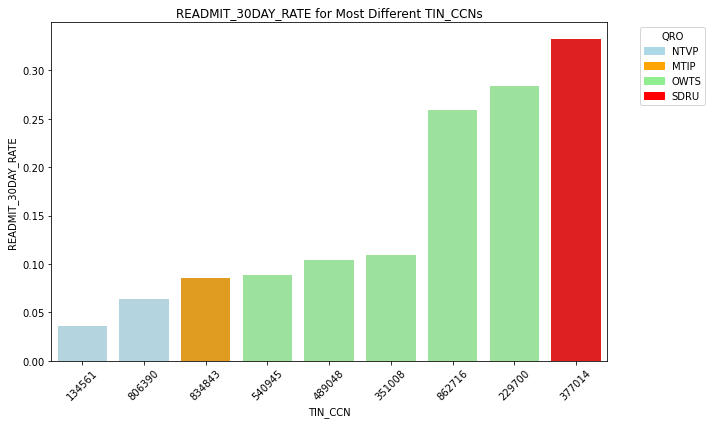

In [38]:
# Extract TIN_CCN values from the Tukey HSD results DataFrame
tin_ccn_values = set(most_different_readmit["group1"].tolist() + most_different_readmit["group2"].tolist())

# Filter the quality_metrics_agg DataFrame to include only those TIN_CCN values
filtered_quality_metrics = quality_metrics_agg[quality_metrics_agg["TIN_CCN"].isin(tin_ccn_values)].sort_values('READMIT_30DAY_RATE',ascending=True)

# Create a unique color for each QRO category
palette = {"NTVP": "lightblue", "MTIP": "orange", "OWTS": "lightgreen", "SDRU": "red"}
filtered_quality_metrics['color'] = filtered_quality_metrics['QRO'].map(palette)

# Plotting the READMIT_30DAY_RATE for the filtered TIN_CCN values
plt.figure(figsize=(10, 6))
sns.barplot(data=filtered_quality_metrics, x="TIN_CCN", y="READMIT_30DAY_RATE", 
            order=filtered_quality_metrics['TIN_CCN'].tolist(), palette=filtered_quality_metrics['color'].tolist())
plt.title("READMIT_30DAY_RATE for Most Different TIN_CCNs")
plt.xticks(rotation=45)
plt.xlabel("TIN_CCN")
plt.ylabel("READMIT_30DAY_RATE")
handles = [plt.Rectangle((0,0),1,1, color=palette[label]) for label in palette]
plt.legend(handles, palette.keys(), title="QRO", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [27]:
low_readmit_tin = [134561,806390,834843,540945,489048,351008]

low_readmit_provider_df = provider_df[provider_df.TIN_CCN.isin(low_readmit_tin)]
low_readmit_provider_df = low_readmit_provider_df.replace(0,np.nan).dropna()
low_readmit_provider_df


,PERFORMANCE_YEAR,QRO,TIN_CCN,SUM_IP_SPEND,SUM_FAC_OP_SPEND,SUM_PHY_SPEND,SUM_POSTACUTE_SPEND,SUM_HOSPICE_SPEND,SUM_DME_SPEND,ED_VISIT_RATE,ED_RETURN_72HRS,IP_ADMIT_RATE,READMIT_30DAY_RATE,AWV_RATE,SUM_PCP_VISITS,CNT_PCP_VISITS,SUM_SPEC_VISITS,CNT_SPEC_VISITS
6,2019,MTIP,834843,5364179.15,4602899.62,3152931.99,1253099.57,433572.46,548635.03,688.6,0.696,230.1,0.094,0.120,954668.84,8647.0,263161.19,4254.0
17,2019,OWTS,351008,1240316.20,651429.46,727782.10,369998.02,105680.92,84767.70,688.3,0.665,324.7,0.080,0.562,99926.49,1458.0,71464.71,1119.0
33,2019,OWTS,489048,1218381.67,895543.02,881826.93,407999.65,22037.02,82251.38,587.6,0.638,253.4,0.117,0.744,131826.41,1637.0,93923.47,1468.0
43,2020,MTIP,834843,3870672.72,3611136.55,2416874.84,794411.59,263022.25,464303.70,534.3,0.751,173.3,0.065,0.078,706569.40,7037.0,212975.25,3424.0
60,2020,OWTS,351008,810827.69,538723.82,498803.24,131392.34,8051.84,88303.58,466.0,0.657,200.7,0.085,0.473,74211.92,1130.0,50241.25,772.0
75,2020,OWTS,489048,682272.18,528324.76,618138.21,235659.20,60015.33,101396.26,320.4,0.638,121.5,0.114,0.771,102388.53,1265.0,70152.86,1076.0
77,2020,OWTS,540945,500974.05,420568.22,503053.08,158250.43,10005.38,206479.32,448.9,0.519,233.0,0.098,0.534,59973.07,800.0,64231.35,891.0
92,2021,MTIP,834843,5134467.39,4088926.43,2321431.82,914249.13,139960.53,424339.33,650.6,0.712,208.9,0.108,0.035,725211.45,6664.0,260990.28,3459.0
120,2021,OWTS,351008,940148.09,591679.20,610146.80,213819.55,51737.73,75946.77,563.8,0.629,212.8,0.117,0.553,91608.57,1136.0,64733.45,852.0
134,2021,OWTS,489048,690863.68,609265.64,840141.16,277763.42,58743.47,279020.82,408.2,0.658,153.4,0.071,0.803,139124.43,1490.0,101392.19,1266.0


In [28]:
high_readmit_tin = [862716,229700,377014]
high_readmit_provider_df = provider_df[provider_df.TIN_CCN.isin(high_readmit_tin)]
high_readmit_provider_df

,PERFORMANCE_YEAR,QRO,TIN_CCN,SUM_IP_SPEND,SUM_FAC_OP_SPEND,SUM_PHY_SPEND,SUM_POSTACUTE_SPEND,SUM_HOSPICE_SPEND,SUM_DME_SPEND,ED_VISIT_RATE,ED_RETURN_72HRS,IP_ADMIT_RATE,READMIT_30DAY_RATE,AWV_RATE,SUM_PCP_VISITS,CNT_PCP_VISITS,SUM_SPEC_VISITS,CNT_SPEC_VISITS
23,2019,OWTS,862716,278950.29,149833.50,184982.33,34364.39,28787.30,26402.35,455.4,0.652,178.2,0.056,0.059,25265.81,461,19266.30,305
66,2020,OWTS,862716,246118.15,86383.26,175301.05,41274.93,0.00,14599.90,285.7,0.542,166.7,0.214,0.048,14266.59,341,14244.62,241
117,2021,OWTS,229700,624506.42,307205.80,318754.07,88664.09,140757.33,18149.10,876.4,0.679,561.8,0.240,0.202,38656.32,508,44180.50,507
125,2021,OWTS,862716,88237.40,82680.29,141032.00,9467.03,1876.55,5950.28,189.9,0.333,63.3,0.600,0.063,20091.81,388,16827.77,215
208,2022,OWTS,229700,801302.18,222943.34,324332.66,132082.58,37470.48,29749.14,1085.7,0.588,609.5,0.406,0.238,42126.87,554,45523.50,565
215,2022,OWTS,862716,54704.03,65670.15,75656.09,21972.87,27249.83,3442.31,333.3,0.294,117.6,0.167,0.118,13377.28,242,9181.31,119
319,2023,OWTS,229700,740856.36,133190.45,218865.92,70491.58,17513.97,12100.65,595.5,0.094,382.0,0.206,0.303,26377.52,335,28497.75,366
326,2023,OWTS,862716,0.00,117.55,994.08,0.00,0.00,0.00,0.0,0.000,0.0,0.000,0.000,0.00,0,525.71,8
354,2023,SDRU,377014,61445.64,21510.51,21595.78,0.00,0.00,774.95,1666.7,0.800,1000.0,0.333,0.000,2893.17,45,1859.43,22


In [29]:
# Multiple regression for low readmit group
X_low = sm.add_constant(low_readmit_provider_df[['SUM_IP_SPEND', 'SUM_FAC_OP_SPEND', 'SUM_PHY_SPEND', 'SUM_POSTACUTE_SPEND', 'SUM_HOSPICE_SPEND', 'SUM_DME_SPEND']])  # adding a constant
model_low = sm.OLS(low_readmit_provider_df['READMIT_30DAY_RATE'], X_low).fit()

# Multiple regression for high readmit group
X_high = sm.add_constant(high_readmit_provider_df[['SUM_IP_SPEND', 'SUM_FAC_OP_SPEND', 'SUM_PHY_SPEND', 'SUM_POSTACUTE_SPEND', 'SUM_HOSPICE_SPEND', 'SUM_DME_SPEND']])
model_high = sm.OLS(high_readmit_provider_df['READMIT_30DAY_RATE'], X_high).fit()

print("Low Readmit Regression Summary:\n", model_low.summary())
print("High Readmit Regression Summary:\n", model_high.summary())


Low Readmit Regression Summary:
                             OLS Regression Results                            
Dep. Variable:     READMIT_30DAY_RATE   R-squared:                       0.255
Model:                            OLS   Adj. R-squared:                 -0.043
Method:                 Least Squares   F-statistic:                    0.8543
Date:                Mon, 15 Apr 2024   Prob (F-statistic):              0.549
Time:                        13:55:19   Log-Likelihood:                 45.987
No. Observations:                  22   AIC:                            -77.97
Df Residuals:                      15   BIC:                            -70.34
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
c

/Users/wzyy/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [30]:
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# Calculate VIF for each group
print(calculate_vif(X_low.iloc[:, 1:]))  # exclude the constant term
print(calculate_vif(X_high.iloc[:, 1:]))


              variable        VIF
0         SUM_IP_SPEND  90.144940
1     SUM_FAC_OP_SPEND  75.038349
2        SUM_PHY_SPEND  65.430226
3  SUM_POSTACUTE_SPEND  42.416250
4    SUM_HOSPICE_SPEND   9.748689
5        SUM_DME_SPEND  18.035117
              variable         VIF
0         SUM_IP_SPEND   23.849851
1     SUM_FAC_OP_SPEND  661.858030
2        SUM_PHY_SPEND  278.815425
3  SUM_POSTACUTE_SPEND   28.903429
4    SUM_HOSPICE_SPEND   78.292069
5        SUM_DME_SPEND   23.784086


In [31]:
# Drop the variable with the highest VIF from the dataset
X_high_adjusted = high_readmit_provider_df.drop(['READMIT_30DAY_RATE', 'SUM_FAC_OP_SPEND','PERFORMANCE_YEAR','QRO','TIN_CCN'], axis=1)
y_high = high_readmit_provider_df['READMIT_30DAY_RATE']

# Scaling the features
scaler = StandardScaler()
X_high_scaled = scaler.fit_transform(X_high_adjusted)

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X_high_scaled, y_high, test_size=0.2, random_state=0)

# Fitting Ridge Regression to the dataset
ridge_reg = Ridge(alpha=1.0)
ridge_reg.fit(X_train, y_train)

# Evaluating the model
ridge_reg.score(X_test, y_test)  # Returns the coefficient of determination R^2 of the prediction.

# Checking coefficients
coefficients = pd.DataFrame({'Variable': X_high_adjusted.columns, 'Coefficient': ridge_reg.coef_})
print(coefficients)


               Variable  Coefficient
0          SUM_IP_SPEND    -0.051057
1         SUM_PHY_SPEND     0.035467
2   SUM_POSTACUTE_SPEND    -0.006386
3     SUM_HOSPICE_SPEND    -0.076536
4         SUM_DME_SPEND    -0.129447
5         ED_VISIT_RATE     0.025962
6       ED_RETURN_72HRS    -0.017562
7         IP_ADMIT_RATE     0.033559
8              AWV_RATE    -0.053019
9        SUM_PCP_VISITS     0.062500
10       CNT_PCP_VISITS     0.062163
11      SUM_SPEC_VISITS     0.082344
12      CNT_SPEC_VISITS     0.035041


## Predict Model

In [32]:
columns_to_normalize = [
    'SUM_IP_SPEND', 'SUM_FAC_OP_SPEND', 'SUM_PHY_SPEND', 'SUM_POSTACUTE_SPEND',
    'SUM_HOSPICE_SPEND', 'SUM_DME_SPEND'
]
scaler = StandardScaler()
normalized_data = scaler.fit_transform(provider_df[columns_to_normalize])
pca = PCA(n_components=2)
pca_results = pca.fit_transform(normalized_data)
pca_results[:10]

array([[-6.04168218e-01, -2.39201597e-02],
       [-6.05088790e-01, -2.35047930e-02],
       [-6.05092773e-01, -2.35021785e-02],
       [-5.81698014e-01, -3.54484675e-02],
       [ 3.43141959e+00,  9.51431413e-01],
       [ 1.15103663e+00,  5.81100328e-02],
       [ 6.67511963e-01,  2.78396010e-01],
       [-5.60195428e-01,  1.92290284e-03],
       [-5.57040352e-01, -1.03011967e-02],
       [ 2.67582518e+00,  6.74845532e-01]])

In [33]:
provider_df['Composite_Score'] = np.mean(pca_results,axis=1)
provider_df.sort_values(['Composite_Score'],ascending=False)

,PERFORMANCE_YEAR,QRO,TIN_CCN,SUM_IP_SPEND,SUM_FAC_OP_SPEND,SUM_PHY_SPEND,SUM_POSTACUTE_SPEND,SUM_HOSPICE_SPEND,SUM_DME_SPEND,ED_VISIT_RATE,ED_RETURN_72HRS,IP_ADMIT_RATE,READMIT_30DAY_RATE,AWV_RATE,SUM_PCP_VISITS,CNT_PCP_VISITS,SUM_SPEC_VISITS,CNT_SPEC_VISITS,Composite_Score
150,2021,UPLN,430950,1.157051e+08,1.029321e+08,49861810.98,19439312.55,5146075.20,13704945.35,627.0,0.664,298.6,0.166,0.521,7081575.74,103652,8110220.90,105152,10.721399
36,2019,UPLN,430950,8.544768e+07,7.822179e+07,38538912.62,19358636.27,5720443.16,9926466.01,711.7,0.725,311.9,0.155,0.538,5301353.91,92567,4853907.06,79657,10.614587
374,2023,UPLN,430950,9.120167e+07,1.038906e+08,45205399.56,16566489.25,4959034.98,12522399.53,570.2,0.347,263.1,0.144,0.557,7187374.93,98494,6912164.51,94264,9.815823
262,2022,UPLN,430950,1.035069e+08,1.140001e+08,48869509.68,18873166.67,4383509.25,13221610.67,616.4,0.581,284.9,0.167,0.566,7499218.50,103337,7637417.84,101539,9.779160
78,2020,UPLN,430950,1.085706e+08,8.835376e+07,40798211.80,18870273.58,3884250.87,13198513.82,587.5,0.697,281.2,0.160,0.499,5320521.76,96600,5698056.74,90345,8.920521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,2021,NTVP,806390,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.00,0.0,0.000,0.0,0.000,0.000,0.00,0,0.00,0,-0.314298
107,2021,NTVP,855505,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.00,0.0,0.000,0.0,0.000,0.000,0.00,0,0.00,0,-0.314298
106,2021,NTVP,860485,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.00,0.0,0.000,0.0,0.000,0.000,0.00,0,0.00,0,-0.314298
105,2021,NTVP,134561,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.00,0.0,0.000,0.0,0.000,0.000,0.00,0,0.00,0,-0.314298


In [34]:
X = provider_df.drop(['PERFORMANCE_YEAR', 'QRO', 'TIN_CCN', 'Composite_Score'],axis=1)
y = provider_df['Composite_Score']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
model = RandomForestRegressor(n_estimators=100, random_state=42)

model.fit(X_train_scaled,y_train)

y_pred = model.predict(X_test_scaled)


In [35]:
mse = mean_squared_error(y_test,y_pred)
print(f'Mean Squared Error: {mse}')
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")

Mean Squared Error: 0.015267177967899871
R-squared: 0.9937120582587362


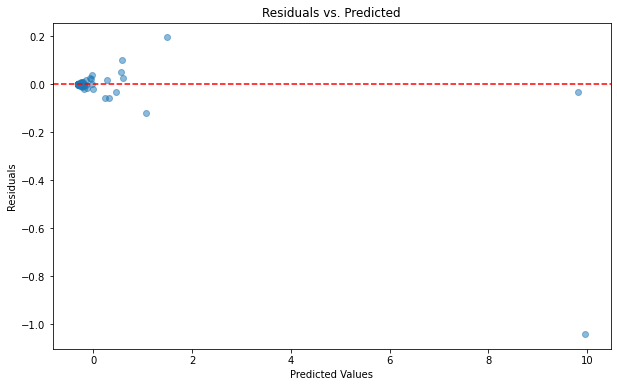

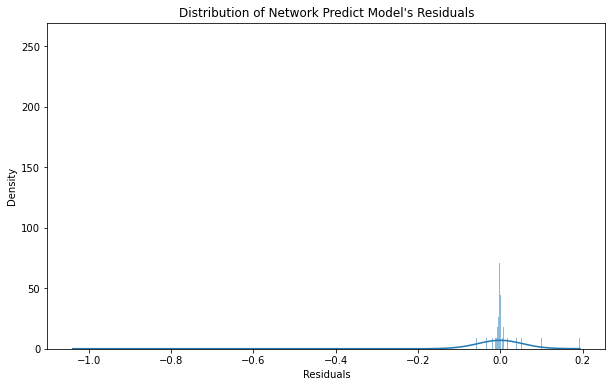

In [36]:
residuals = y_test - y_pred
# Basic Residual Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.title('Residuals vs. Predicted')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

# Checking for normality of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, stat="density", linewidth=0)
plt.title('Distribution of Network Predict Model\'s Residuals')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()

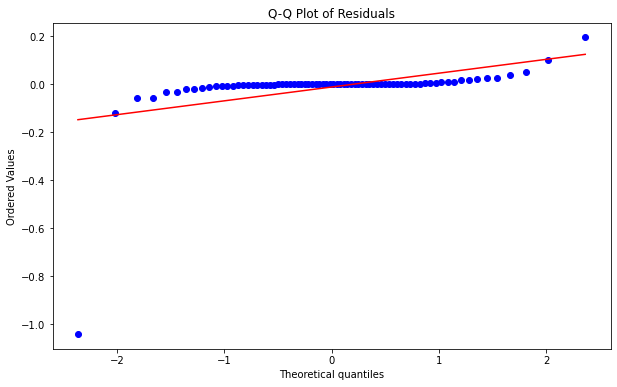

In [37]:
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()